Dependencies:

In [1]:
#%matplotlib ipympl

import math
import sys
import time
import sympy as sp
import numpy as np
from func_timeout import func_timeout as ftim
from copy import deepcopy
import scipy as sci
import tkinter as tk

from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as patches
from sympy.plotting.plot import MatplotlibBackend, Plot

Helper Functions:

---Managing Functions:

In [2]:
def get_params(fun):           #gets parameter names from a string input
    if type(fun) == list:
        funs = ''
        for function in fun:
            funs += str(function) + " "
        fun = funs
    fun = fun.replace('(', '( ').replace(')', ' ) ').replace('/', ' / ').replace('+', ' + ')
    fun = fun.replace('-', ' - ').replace('*', ' * ').replace('*  *', '**')
    fun = fun.replace("(", " ").replace(")", " ").split(" ")
    remove = []
    for param in fun:
        if param == "" or (not param[0:1].isalpha()) or param[0] == "x" or len(param) > 2:
            remove.append(param)
    for item in remove:
        fun.remove(item)
    fun.sort()
    for param in fun:
        count = fun.count(param)
        for i in range(count - 1):
            fun.remove(param)
    return fun 


def define_fun(fun):                         #defines a function based on string input
    fun = fun.replace('exp', 'np.exp').replace('cos', 'np.cos').replace('sin', 'np.sin').replace('tan', 'np.tan')
    fun = fun.replace('abs', 'np.abs').replace('cosh', 'np.cosh').replace('sinh', 'np.sinh').replace('tanh', 'np.tanh')
    return lambda x1, x2, x3, x4, params : eval(fun)


def define_eqn_sys_3d(functions: list):       #define a list of functions based on an input list of strings
    funs = deepcopy(functions)
    params = get_params(funs)
    ans = []
    for i in range(len(params)):
        for j in range(len(funs)):
            funs[j] = funs[j].replace('(', '( ').replace(')', ' ) ').replace('/', ' / ').replace('+', ' + ')
            funs[j] = funs[j].replace('-', ' - ').replace('*', ' * ').replace('*  *', '**').split(' ')
            for k in range(len(funs[j]) - 1, -1, -1):
                if funs[j][k] == f'{params[i]}':         #replaces param name with param value
                    funs[j][k] = f'params[{i}]'
            temp = ''
            for k in funs[j]:
                temp = temp + str(k) + ' '
            funs[j] = temp[:-1:]
            #funs[j] = funs[j].replace(f'{params[i]}', f'params[{i}]')
    for fun in funs:
        ans.append(define_fun(fun))
    return ans


def sympify_list(funs: list, params_in):                  #defines a list of expressions recognizable by sympy
    x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')            #based on a list of strings and parameter values as input
    params = get_params(funs)
    functions = deepcopy(funs)
    for i in range(len(params)):
        for j in range(len(functions)):
            functions[j] = functions[j].replace('(', '( ').replace(')', ' ) ').replace('/', ' / ').replace('+', ' + ')
            functions[j] = functions[j].replace('-', ' - ').replace('*', ' * ').replace('*  *', '**').split(' ')
            for k in range(len(functions[j]) - 1, -1, -1):
                if functions[j][k] == f'{params[i]}':
                    functions[j][k] = f'{params_in[i]}'
            temp = ''
            for k in functions[j]:
                temp = temp + str(k) + ' '
            functions[j] = temp[:-1:]
    for i in range(len(functions)):
        functions[i] = sp.nsimplify(sp.sympify(functions[i]), tolerance = 10e-5)
    return functions

def community_matrix(funs: list = None):    #returns the community matrix / Jacobian of a system of functions
    functions = []                          #based on an input list of string expressions
    variables = []
    if funs == None:                         #if no input is given, function will ask for input from the user
        length = input("Dimension of the system: ")
        for i in range(int(length)):
            fun = input(f"function {i + 1}: ")
            functions.append(fun)
    else:
        functions = funs
    for function in functions:
        function = function.replace('(', '( ').replace(')', ' ) ').replace('/', ' / ')
        function = function.replace('+', ' + ').replace('-', ' - ').replace('*', ' * ')
        function = function.replace('*  *', '**').replace('(', ' ').replace(')', ' ').split(' ')
        for entry in function:
            if entry != "" and entry[0].isalpha():
                if variables.count(entry) == 0:
                    variables.append(entry)       #appends variables to be defined as symbols for sympy
    for variable in variables:
        string = variable
        locals()[string] = sp.symbols(string)
    for i in range(len(functions)):
        string = f'f_{i}'
        locals()[string] = functions[i]
    symbols = []
    for variable in variables:
        if variable[0] == 'x':
            if symbols.count(variable) == 0:
                symbols.append(variable)
    symbols.sort(key = lambda x : int(x[1:]))
    mat = [[sp.sympify(function).diff(symbol) for symbol in symbols] for function in functions]
    return sp.Matrix(mat)



---Finding roots:

In [3]:
def distance(v1, v2):
    ans = 0
    v1, v2 = np.array(v1), np.array(v2)
    v1, v2 = v1.squeeze(), v2.squeeze()
    v1, v2 = v1.tolist(), v2.tolist()
    if type(v1) != list:
        v1 = [v1]
    if type(v2) != list:
        v2 = [v2]
    for i in range(len(v1)):
        ans += (v1[i] - v2[i]) ** 2
    return math.sqrt(ans)

def make_grid(dimensions: int, start, end, samples: int):
    points = np.linspace(start, end, samples)
    points = [[x] for x in points]
    dim = 1
    while dim < dimensions:
        temp = np.linspace(start, end, samples)
        current = []
        for x1 in points:
            for x2 in temp:
                coord = x1 + [x2]
                current.append(coord)
        points = deepcopy(current)
        dim += 1
    zero = [0 for i in range(dim)]
    points.append(zero)
    return points
        

def test_zero(fun, points, params, tolerance = 0.01, pad = 0):  #takes in a set of points and returns 
    ans = []                                                    #a subset of points at which value 
    for point in points:                                        #of function is below tolerance
        try:
            val = fun(*point, *[0 for i in range(pad)], params)
        except:
            pass
        else:
            if abs(val) < tolerance:
                ans.append(point)
    return ans


def test_zero_all(functions, points, params, tolerance = 0.1, pad = 0):
    while True:
        points_temp = deepcopy(points)
        for function in functions:
            points_temp = test_zero(function, points_temp, params, tolerance, pad)
        if len(points_temp) != 0 or tolerance > 5.2:
            return points_temp
        else:
            tolerance += 1

            
def eval_eigens(eigens):
    eigen_temp = []
    for key, value in eigens.items():
        for k in range(value):
            eigen_temp.append(key)
    eigens = eigen_temp
    stable = 1
    degen = False
    for e in eigens:
        e1 = sp.re(e)
        if e1 > 0:
            stable = -1
    if stable == 1:
        for e in eigens:
            if e1 == 0:
                degen = True 
                break
    e1 = int(not degen) * stable
    return (e1, eigens)
            
            
def find_solutions(functions, points, params,     
                   tolerance=0.1, pad = 0, jacobian = None, param_names = None):
                                                #finds roots of a system of equations
    if jacobian is not None:                    #numerically and symbolically and      
        jacob = deepcopy(jacobian)              #returns them along with eigenvalues
        subs = []                               #of jacobian evaluated at the roots
        for i in range(len(param_names)):
            subs.append((param_names[i], params[i]))
        jacob = jacob.subs(subs)
        
    funs = deepcopy(functions)
    functions = define_eqn_sys_3d(functions)
    ans = []
    points = test_zero_all(functions, points, params, tolerance, pad) #starting points
    funs = sympify_list(funs, params)                            #for numerical search
    x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')  #sympy food
    while len(points) > 36:                 
        points = points[::2]                    #reduce the number of numerical searches
    for point in points:
        point = np.array(point).squeeze()
        try:                                    #numerical search itself
            len_fun = len(funs)
            if len_fun == 3:
                guess = sp.nsolve(funs, (x1, x2, x3), point)
            elif len_fun == 2:
                guess = sp.nsolve(funs, (x1, x2), point)
            elif len_fun == 4:
                guess = sp.nsolve(funs, (x1, x2, x3, x4), point)
            else:
                guess = sp.nsolve(funs[0], (x1), point.tolist())
        except:
            pass
        else:
            add = True
            for root in ans:
                if distance(root[0], guess) < 10**(-5):  #check if root is already listed
                    add = False
            if add:
                try:
                    if type(guess) != list and type(guess) != sp.matrices.dense.MutableDenseMatrix:
                        guess= [guess]
                    subs = []
                    for i in range(len(guess)):
                        guess[i] = float(guess[i])
                        subs.append((eval(f'x{i + 1}'), guess[i]))
                    eigens = jacob.subs(subs).eigenvals()
                    guess = np.array(guess).squeeze()
                    guess = np.array([guess, *eval_eigens(eigens)])
                    ans.append(guess)
                except:
                    pass
        if len(ans) > 15:
            break
    ans1 = []
    try:
        if len(funs) == 3:    #run_with_timeout limits the time of symbolic root search
            guess1 = run_with_timeout(sp.solve, 15, args = [funs, x1, x2, x3], kwargs = {'check' : False})
        elif len(funs) == 2:  #sympy really likes taking an eternity with long expressions or fractional powers
            guess1 = run_with_timeout(sp.solve, 15, args = [funs, x1, x2], kwargs = {'check' : False})
        elif len(funs) == 4:
            guess1 = run_with_timeout(sp.solve, 20, args = [funs, x1, x2, x3, x4], kwargs = {'check' : False})
        else:
            guess1 = run_with_timeout(sp.solve, 15, args = [funs[0], x1], kwargs = {'check' : False})
        
        if type(guess1) == dict:      #this abomination spits out a np.array of [root, stability, eigenvalues]
            guess1 = [[vals] for vals in guess1.values()]
            guess1 = [[guess1[i][j] for i in range(len(guess1))] for j in range(len(guess1[0]))]
        if type(guess1[0]) != list and type(guess1[0]) != tuple:
            guess1 = [[g] for g in guess1]
        guess1 = [[*g] for g in guess1]
        guess1 = [[g for g in guess1[i]] for i in range(len(guess1))]
        for g in guess1:
            subs = []                         #list of substitutions for sympy
            for i in range(len(g)):
                subs.append((eval(f'x{i + 1}'), g[i]))    
            eigens = jacob.subs(subs).eigenvals()
            add = True
            for fun in funs:
                value = fun.subs(subs)
                try:
                    result = float(value)
                    if abs(result) > 1e-2:    #fact-checks the solution
                        add = False
                except:
                    pass
                    add = False
            if add:
                g = [g1.evalf(5) for g1 in g]
                g = np.array(g).squeeze()
                g = [g, *eval_eigens(eigens)]
                ans1.append(np.array(g))
    except:
        pass
    return np.array(ans), ans1   #ans - numerical roots, ans1 - symbolic roots

---Misc:

In [4]:
def display_mat(mat, inline = False):       #displays a matrix in readable format
    rows, columns = len(mat), len(mat[0])   #inline false causes long matrices to be
    max_len = [0 for entry in range(columns)]  #displayed one element per line instead
    len_total = 0                            #of one row per line
    for i in range(rows):
        current = 0
        for j in range(columns):
            max_len[j] = max(max_len[j], len(str(mat[i][j])))
            current += len(str(mat[i][j]))
        len_total = max(len_total, current)
    long = False
    if max(max_len) > 20:
        long = True                         #signal that matrix is too large to display
    if len_total > 25 and not inline:       #in the app
        ans = ""
        for i in range(rows):
            current = "["
            for j in range(columns):
                string = str(mat[i][j])
                string += " " 
                current = current + string + ",\n"
            current = current[0:-2] + "]\n"
            ans += current
        return [ans[0:-1], long]
    ans = ""
    for i in range(rows):
        current = "["
        for j in range(columns):
            string = str(mat[i][j])
            string += " " * ((max_len[j] - len(string)))
            current = current + string + ", "
        current = current[0:-2] + "]\n"
        ans += current
    return [ans[0:-1], long]


def remove_large(fun, x, y, params):    #sets large values to NaN so matplotlib doesn't   
    a = fun(x, y, 0, 0, params)         #connect contours over asymptotes

    for i in range(len(a)):
        for j in range(len(a[0])):
            a[i][j] = to_nan(a[i][j])
    return a


def to_nan(x):                          #value -> NaN
    return x if abs(x) < 5 else np.nan


def run_with_timeout(fun, time, args = None,  kwargs = None, default = []):
    try:                                       #imposes time limit on the execution a function
        val = ftim(time, fun, args, kwargs)
        return val
    except func_timeout.FunctionTimedOut:
        pass
    return default

The app itself:

C:\Users\Andrzej Socha\AppData\Local\Temp\ipykernel_24808\2122818596.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  guess = np.array([guess, *eval_eigens(eigens)])
C:\Users\Andrzej Socha\AppData\Local\Temp\ipykernel_24808\2122818596.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ans1.append(np.array(g))


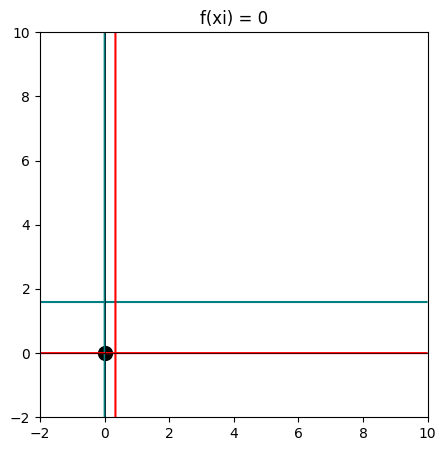

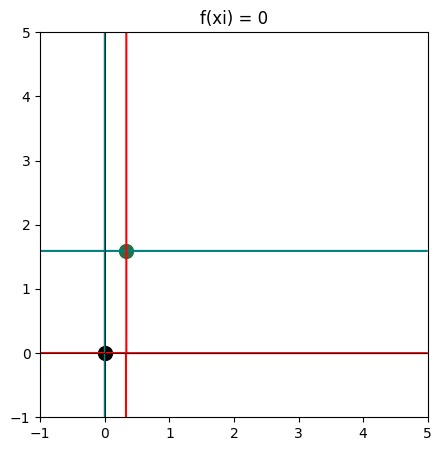

In [7]:
if __name__ == '__main__':
    
    #sys.stdout = open('nul', 'w')
    #sys.stderr = open('nul', 'w')

    def self_close():
        root.quit()
        root.destroy()
    
    root = tk.Tk()
    root.title('Differential System Analysis')
    root.protocol("WM_DELETE_WINDOW", self_close) #necessary for exe to close after closing the window
    


    def fun_entry():               #creates the function entry boxes after dimension has been confirmed
        global current_params, trajectories_box
        current_params = []
        dim = dim_text.get()
        if 0 < int(dim) < 5:
            global fun_entries, funziez
            try:
                for item in funziez:
                    item.destroy()
                trajectories_box.destroy()
            except:
                pass
            funziez = []
            fun_entries = []
            fun_boxes = tk.PanedWindow(bar_top, background = "#d5e8d4")
            fun_boxes.pack(side = 'left', padx = 3, pady = 2)
            for i in range(int(dim)):
                fun_frame = tk.Frame(fun_boxes, border = 5,relief = 'sunken', background = '#D0E1CF')
                fun_entry = tk.Entry(fun_frame, width = 80, border = 0)
                fun_entry.insert(0, f'function {i + 1}, vars : x1, x2 ...')
                fun_frame.pack(side = 'top', pady = 2)
                fun_entry.pack()
                fun_entries.append(fun_entry)
            confirm_funs_area = tk.PanedWindow(bar_top, background = "#d5e8d4")
            confirm_funs = tk.Button(confirm_funs_area, text = 'Confirm functions',
                                     command = lambda : init_graph(fun_entries, graph_area), background = '#E9FAE8')
            confirm_funs_area.pack(side = 'left', padx = 5)
            confirm_funs.pack(side = "left")
            current_heigth = max(2, i)
            funziez.append(fun_boxes)
            funziez.append(confirm_funs_area)
        else:
            dim_text.delete(0, len(dim))
            dim_text.insert(0, "Enter an integer between 1 and 4")


    def update_param(i, sign):                         #updates the current parameters
        current = param_controls[i][2].get()
        current_len = len(current)
        current = round(float(current) + sign * 0.05, 4)
        param_controls[i][2].delete(0, current_len)
        param_controls[i][2].insert(0, str(current))


    def init_graph(fun_entries, root):                   #Handles the events after user inputs the functions
        for child in bar_parameters.winfo_children():    #clears the area of widgets from previous calls
            child.destroy()
        global functions_from_entry, param_names
        functions_from_entry = []
        for entry in fun_entries:
            functions_from_entry.append(entry.get())

        params = get_params(functions_from_entry)
        param_names = deepcopy(params)
        if len(params) != 0:                             #skips subbing in parameters if there are none
            if len(params) > 18:
                view_custom_jacobian('Too many parameters, max is 18') #error popup if too many params
                return
            param_fill = tk.PanedWindow(bar_parameters, width = 8, background = '#D0E7E0')
            param_fill.pack(side = 'left')
            global param_controls
            param_controls = []
            for i in range(len(params)):                 #creates a control widget for every parameter
                current = []
                param_box = tk.LabelFrame(bar_parameters, background = '#D0E7E0')
                param_name = tk.Label(param_box, text = f'{params[i]}: ', background = '#D0E7E0')
                param_value = tk.Entry(param_box, width = 7, border = 3)
                param_value.insert(0, "1")
                button_up = tk.Button(param_box, text = "⮝", width = 2,
                                      command = lambda index = i: update_param(index, 1), background = '#D0E7E0')
                button_down = tk.Button(param_box, text = "⮟", width = 2,
                                        command = lambda index = i: update_param(index, -1), background = '#D0E7E0')
                current.append(param_box)
                current.append(param_name)
                current.append(param_value)
                current.append(button_up)
                current.append(button_down)
                param_controls.append(current)
                param_box.pack(side = 'left', fill = 'y', padx = 2, pady = 2)
                param_name.grid(row = 0, column = 0, rowspan = 2)
                param_value.grid(row = 0, column = 1, rowspan = 2)
                button_up.grid(row = 0, column = 2)
                button_down.grid(row = 1, column = 2)
            confirm_params = tk.Button(bar_parameters, text = "Confirm parameters",
                                       command = lambda : check_params(), background = '#D0E7E0')
            confirm_params.pack(side = 'left', padx = 3)                 
        else:
            for child in graph_area.winfo_children():
                child.destroy()
            insert_graph_3d(functions_from_entry, [])    


    def check_params():               #recovers the current parameters input by the user
        global current_params
        params = []
        for i in range(len(param_controls)):
            param = param_controls[i][2].get()
            params.append(float(param))
        #if current_params == []:
        current_params = deepcopy(params)
        for child in details_area.winfo_children():
            child.destroy()
        for child in graph_area.winfo_children():
            child.destroy()
        insert_graph_3d(functions_from_entry, params)


    def graph_trajectories():             #initiates graphing of phase space and value/time graphs
        ICs, time = trajectory_args[0].get(), trajectory_args[1].get()
        try:
            time = float(time)
        except:
            trajectory_args[1].delete(0, len(time))
            trajectory_args[1].insert(0, "Input a valid time")
        else:
            if 0 < time < 1000:
                try:
                    temp = eval(ICs)
                except:
                        trajectory_args[0].delete(0, len(ICs))
                        trajectory_args[0].insert(0, 'Input a valid list')
                else:
                    if type(temp) == list and len(temp) == len(fun_entries):
                        for child in bonus_graph_area.winfo_children():
                            child.destroy()
                        bonus_graph = tk.PanedWindow(bonus_graph_area, background = '#e6f0ed')
                        try:
                            if len(temp) == 2 or len(temp) == 3:
                                insert_phase_3d(functions_from_entry, current_params, bonus_graph, temp, time)
                            else:
                                insert_phase_1d(functions_from_entry, current_params, bonus_graph, temp, time)
                            bonus_graph.grid(row = 0, column = 1)
                        except:
                            trajectory_args[1].insert(len(str(time)), " too large: unbounded growth")
                    else:
                        trajectory_args[0].delete(0, len(ICs))
                        trajectory_args[0].insert(0, 'Input a valid list')
            else:
                trajectory_args[1].delete(0, 20)
                trajectory_args[1].insert(0, "Input a time between 0 and 1000")


    def regraph():                                                  #handles resizing the graph based on user input
        global functions_from_entry, current_params
        entry = graph_area.grid_slaves(row = 2, column = 0)[0].winfo_children()[0].winfo_children()[0]
        text = entry.get()
        try:
            bounds = eval(text)
            if type(bounds) == list and len(bounds) == 2:
                insert_graph_3d(functions_from_entry, current_params, *bounds)
            else:
                raise ValueError
        except:
            entry.delete(0, len(text))
            entry.insert(0, 'Enter a valid interval')


    def insert_graph_3d(functions, params, start = -2, end = 10):       #inserting the main graph and 
        for child in graph_area.winfo_children():                       #managing subsequent creation of widgets
            child.destroy()
        colors = ['#EAC9C9', '#C9E4EA' ,'#CBEAC9']
        global jacobian, param_names
        jacobian = sp.simplify(community_matrix(functions))
        for child in details_area.winfo_children():
            child.destroy()

        if len(functions) == 3:                 #returns a matplotlib graph figure and a list of roots
            graph_and_roots = canvas3d(functions, params, graph_area, jacobian, param_names, start = start, end = end)
        elif len(functions) == 2:
            graph_and_roots = canvas2d(functions, params, graph_area, jacobian, param_names, start = start, end = end)
        elif len(functions) == 1:    
            graph_and_roots = canvas1d(functions, params, graph_area, jacobian, param_names, start = start, end = end)
        else:                                   #doesnt graph in case of 4 variables - only finds any roots
            points, solved = find_solutions(functions, make_grid(4, -2, 10, 20),
                                            params, tolerance = 1, pad = 0,
                                            jacobian = jacobian, param_names = param_names)
            graph_and_roots = [0, points, solved]
        if len(functions) != 4:   
            canvas = graph_and_roots[0]
            canvas.draw()

            toolbar = NavigationToolbar2Tk(canvas, graph_area, pack_toolbar = False)
            toolbar.config(background = '#e6f0ed')
            for tool in toolbar.winfo_children():
                tool.config(background = '#e6f0ed')
            toolbar.update()

            canvas.mpl_connect("key_press_event", lambda event: print(f"you pressed {event.key}"))
            canvas.mpl_connect("key_press_event", key_press_handler)

            toolbar.grid(row = 1, column = 0)
            canvas.get_tk_widget().grid(row = 0, column = 0)

            zoom_box = tk.PanedWindow(graph_area, background = '#e6f0ed')     #creating widgets for resizing the graph
            zoom_frame = tk.Frame(zoom_box, relief = 'sunken', border = 3, background = '#e6f0ed')
            zoom_entry = tk.Entry(zoom_frame, width = 30)
            zoom_entry.insert(0, 'Enter new interval as a list:')
            zoom_button = tk.Button(zoom_box, text = 'Resize graph:',
                                    command = regraph, width = 20, background = '#D9E9E4')
            zoom_box.grid(row = 2, column = 0)
            zoom_frame.pack(side = 'top', pady = 3, padx = 5)
            zoom_entry.pack()
            zoom_button.pack(side = 'top', pady = 5)

        jacobian_area = tk.LabelFrame(details_area, background = '#E9F4F1')       #managing the middle strip of the app
        jacobian_area.pack(side = 'top', pady = 2, fill = 'x')
        jacobian_text = display_mat(np.array(jacobian))
        jacobian_text = jacobian_text[0] if not jacobian_text[1] else 'Too large to display\nClick to view'
        jacobian_box = tk.Button(jacobian_area, text = jacobian_text, font = ('courier', 11),
                                 command = view_jacobian, background = '#D0E7E0')

        jacobian_label = tk.Label(jacobian_area, text = "Community\nMatrix", background = '#E9F4F1')
        jacobian_label.pack(side = "top",)
        jacobian_box.pack(side = "top", pady = 3, fill = 'x')

        solved = graph_and_roots[2]               #handles displaying the symbolically found roots
        solved_box = tk.LabelFrame(details_area, background = '#E9F4F1')
        solved_box.pack(side = 'top', fill = 'x', pady = 5)
        solved_label = tk.Label(solved_box, text = 'Symbolically found\nsteady states:', background = '#E9F4F1')
        solved_label.pack(side = 'top')
        if len(solved) == 0:                     #if no roots are found creates a button with 'none found'
            solved_none = tk.Button(solved_box, text = "None found", background = '#D0E7E0')
            solved_none.pack(side = 'top', padx = 3, pady = 3, fill = 'x')
            
        elif len(solved) > 6:   #if too mnay roots are found they can be viewed in a separate popup
            stability = ['Unstable', 'Stability indecisive', 'Stable']
            try:
                solved = solved.tolist()
            except:
                pass
            for i in range(len(solved)):
                try:
                    solved[i][0] = [x.evalf(5).round(3) for x in solved[i][0]]
                except:
                    pass
                try:
                    solved[i][2] = [x.evalf(5).round(3) for x in solved[i][2]]
                except:
                    pass
                
                solved[i] = 'Coords: ' + str(solved[i][0]) + ' | ' + \
                'Eigens: ' +  str(solved[i][2]) + ' | ' + stability[int(solved[i][1]) + 1]
                
            string = '\n--------------------------------------\n'.join(solved)
            solved_root = tk.Button(solved_box, text = 'Click to view all',
                                    command = lambda x = string : view_custom_jacobian(x, font_size = 15),
                                    background = '#D0E7E0')
            solved_root.pack(side = "top", pady = 3, padx = 3, fill = 'x')
            
        else:
            for root in solved:    #creates a button for each root, colored based on stability, click for eigenvalues
                try:
                    coords = [x.evalf(4).round(3) for x in root[0]]
                except:
                    try:
                        coords = root[0].item()
                        if type(coords) == float:
                            coords = round(coords, 3)
                    except:
                        coords = root[0]
                coords = str(coords)
                stable = int(root[1]) + 1
                eigens = [x.evalf(3) for x in root[2]]
                eigens = str(eigens)
                string = coords if len(coords) < 20 else 'Click to view'
                stability = ['Unstable', 'Stability indecisive', 'Stable']
                display = 'Coordinates:\n' + coords + '\n\nEigenvalues:\n' + eigens + '\n\n' + stability[stable]
                solved_root = tk.Button(solved_box, text = string,
                                        command = lambda x = display : view_custom_jacobian(x),
                                        background = colors[stable])
                solved_root.pack(side = "top", pady = 3, padx = 3, fill = 'x')

        numerical_roots = tk.LabelFrame(details_area, background = '#E9F4F1')
        numerical_roots.pack(side = 'top', fill = 'x', pady = 5)
        steady_state_label = tk.Label(numerical_roots, text = "Numerically found\nsteady states:",
                                      background = '#E9F4F1')
        steady_state_label.pack(side = "top")
        global steady_states
        steady_states = graph_and_roots[1]           #handles displaying the numerically found roots
        if len(steady_states) > 8:                   #if list is too long they can be viewed in a separate popup 
            stability = ['Unstable', 'Stability indecisive', 'Stable']   #window along with eigenvalues 
            steady_states = steady_states.tolist()                       #and stability evaluation
            for i in range(len(steady_states)):
                steady_states[i][0] = [x.evalf(5).round(3) for x in steady_states[i][0]]
                steady_states[i][2] = [x.evalf(5).round(3) for x in steady_states[i][2]]
                
                steady_states[i] = 'Coords: ' + str(steady_states[i][0]) + ' | ' + \
                'Eigens: ' +  str(steady_states[i][2]) + ' | ' + stability[int(steady_states[i][1]) + 1]
                
            string = '\n--------------------------------------\n'.join(steady_states)
            solved_root = tk.Button(numerical_roots, text = 'Click to view all',
                                    command = lambda x = string : view_custom_jacobian(x, font_size = 15),
                                    background = '#D0E7E0')
            solved_root.pack(side = "top", pady = 3, padx = 3, fill = 'x')
        else:
            for root in steady_states:   #creates a button for every steady state, 
                try:                     #colored based on stability, click for eigenvalues
                    coords = [x.evalf(4).round(3) for x in root[0]]
                except:
                    coords = root[0].item()
                    if type(coords) == float:
                        coords = round(coords, 3)
                coords = str(coords)
                stable = int(root[1]) + 1
                eigens = [x.evalf(3) for x in root[2]]
                eigens = str(eigens)
                string = coords if len(coords) < 20 else 'Click to view'
                stability = ['Unstable', 'Stability indecisive', 'Stable']
                display = 'Coordinates:\n' + coords + '\n\nEigenvalues:\n' + eigens + '\n\n' + stability[stable]
                solved_root = tk.Button(numerical_roots, text = string,
                                        command = lambda x = display : view_custom_jacobian(x),
                                        background = colors[stable])
                solved_root.pack(side = "top", pady = 3, padx = 3, fill = 'x')
                
        if len(steady_states) == 0:    #if no roots were found creates a button with "Couldn't find steady states"
            steady_state = tk.Button(numerical_roots, text = "Couldn't find\nsteady states",
                                     background = '#D0E7E0')
            steady_state.pack(side = "top", pady = 3, padx = 3, fill = 'x')
        eval_jacobian_box = tk.LabelFrame(details_area, background = '#E9F4F1')
        eval_button = tk.Button(eval_jacobian_box, text = 'Evaluate Jacobian\nat a custom point',
                                command = lambda : eval_jacobian(), background = '#D0E7E0')
        
        global eval_mat_button, eval_entry
        eval_mat_button = tk.Button(eval_jacobian_box, text = '',
                                    font = ('courier', 10), background = '#D9E9E4')
        eval_entry = tk.Entry(eval_jacobian_box, width = 18, border = 2)
        eval_entry.insert(0, 'Enter a point as a list')
        eval_jacobian_box.pack(side = 'top', fill = 'x')
        eval_button.pack(side = 'top', fill = 'x', pady = 3)
        eval_entry.pack(side = 'top', pady = 5, padx = 3)
        global trajectories_box
        try:
            trajectories_box.destroy()
        except:
            pass                        #handling the trajectory graphing widgets (top right corner of the app)
        trajectories_box = tk.PanedWindow(bar_top, background = "#d5e8d4")     
        trajectories_entry_box = tk.PanedWindow(trajectories_box, background = "#d5e8d4")
        trajectories_button = tk.Button(trajectories_box, text = "Graph trajectories",
                                        command = lambda : graph_trajectories(), background = '#E9FAE8')
        trajectories_entry_IC_frame = tk.Frame(trajectories_entry_box,
                                               border = 5,relief = 'sunken', background = '#D0E1CF')
        trajectories_entry_time_frame = tk.Frame(trajectories_entry_box,
                                                 border = 5,relief = 'sunken', background = '#D0E1CF')
        trajectories_entry_IC = tk.Entry(trajectories_entry_IC_frame, width = 30, borderwidth = 0)
        trajectories_entry_time = tk.Entry(trajectories_entry_time_frame, width = 30, borderwidth = 0)
        trajectories_entry_IC_frame.pack(side = 'top')
        trajectories_entry_time_frame.pack(side = 'top')
        trajectories_box.pack(side = 'left', pady = 5)
        trajectories_entry_box.pack(side = "left", padx = 4)
        trajectories_button.pack(side = "left", padx = 3)
        trajectories_entry_IC.pack(side = "top")
        trajectories_entry_time.pack(side = "top")
        trajectories_entry_IC.insert(0, 'Enter ICs as a list:')
        trajectories_entry_time.insert(0, "Enter amount of time:")
        global trajectory_args
        trajectory_args = [trajectories_entry_IC, trajectories_entry_time]

    def view_jacobian():                                  #shows a popup window with the jacobian
        global jacobian
        message = tk.Toplevel(root, background = '#e6f0ed')
        exit = tk.Button(message, text = 'Exit', width = 12, height = 2,
                         command = lambda : message.destroy(), background = '#D9E9E4')
        x = display_mat(np.array(jacobian), inline = True)[0]
        font_size = 26
        if x.find('\n') > 90:
            y = x.find('\n') - 90
            font_size = int( 26 * (math.pow(2, -math.sqrt(y)/9)) )
        label = tk.Label(message, text = x,
                         font = ('Courier', font_size), background = '#e6f0ed')
        label.pack(side = 'top', pady = 10, padx = 10, expand = True)
        exit.pack(side = 'top')

    def view_custom_jacobian(x, font_size = 26):       #handles all the popup windows 
        message1 = tk.Toplevel(root, background = '#e6f0ed')   #other than the one from jacobian
        exit = tk.Button(message1, text = 'Exit', width = 8,
                         command = lambda : message1.destroy(), background = '#D9E9E4')
        if x.count('\n') > 40:
            y = x.count('\n') - 40
            font_size = int(15 * math.pow(2, - math.sqrt(y/40)))
        label = tk.Label(message1, text = x, font = ('Courier', font_size), background = '#e6f0ed')
        label.pack(side = 'top', pady = 10, padx = 10, expand = True)
        exit.pack(side = 'top', pady = 1)


    def eval_jacobian():                      #evaluates the jacobian at a point input by the user
        global eval_entry, eval_mat_button, functions_from_entry, jacobian, current_params
        params = get_params(functions_from_entry)
        try:
            values = eval(eval_entry.get())
        except:
            eval_point.set('Enter a valid list')       
        else:
            if type(values) == list and len(values) == len(functions_from_entry):
                mat = deepcopy(jacobian)
                subs = []
                for i in range(len(params)):
                    subs.append((str(params[i]), float(current_params[i])))
                mat = mat.subs(subs)
                subs = []
                for i in range(len(fun_entries)):
                    var = f'x{i + 1}'
                    locals()[var] = sp.symbols(f'x{i + 1}')
                    subs.append((eval(f'x{i+1}'), values[i]))        
                mat = mat.subs(subs)

                eigens = []
                for key, val in mat.eigenvals().items():
                    for i in range(val):
                        eigens.append(key.evalf(3))
                eigens = str(eigens)
                string = "Jacobian:\n" + display_mat(np.array(mat.evalf(3)))[0] + '\nEigenvalues:\n'
                eval_mat_button['text'] = string + (eigens if len(eigens) < 20 else 'Click for\neigenvalues')
                eval_mat_button.pack(side = "top", pady = 5, fill = "x")
                eval_mat_button['command'] = lambda x = string + eigens : view_custom_jacobian(x)


    def insert_phase_1d(functions, params, master, ICs, time):         #places the graph and manages its toolbar
        if len(fun_entries) == 1:
            graph = canvas_phase_1d(functions, params, ICs, time,
                                    samples = int(15000 * time), roots = steady_states, master = master)
        if len(fun_entries) == 4:
            graph = canvas_phase_4d(functions, params, ICs, time,
                                    samples = int(15000 * time), roots = steady_states, master = master)
        graph.draw()

        toolbar = NavigationToolbar2Tk(graph, master, pack_toolbar=False)
        toolbar.config(background = '#e6f0ed')
        for tool in toolbar.winfo_children():
            tool.config(background = '#e6f0ed')
        toolbar.update()

        graph.mpl_connect("key_press_event", lambda event: print(f"you pressed {event.key}"))
        graph.mpl_connect("key_press_event", key_press_handler)

        toolbar.grid(row = 1, column = 0)
        graph.get_tk_widget().grid(row = 0, column = 0)


    def insert_phase_3d(functions, params, master, ICs, time):        #places the graphs and manages their toolbars
        
        samples = int( 15000 * (time / (1 + time / 400) ) )           #scaling down samples for large time 
        if len(fun_entries) == 3:                                     #to increase performance
            graph1, graph2 = canvas_phase_3d(functions, params, ICs, time,
                                             samples = samples, roots = steady_states, master = master)
        if len(fun_entries) == 2:
            graph1, graph2 = canvas_phase_2d(functions, params, ICs, time,
                                             samples = samples, roots = steady_states, master = master)
        graph1.draw()
        graph2.draw()

        toolbar1 = NavigationToolbar2Tk(graph1, master, pack_toolbar=False)
        toolbar1.config(background = '#e6f0ed')
        for tool in toolbar1.winfo_children():
            tool.config(background = '#e6f0ed')
        toolbar1.update()

        toolbar2 = NavigationToolbar2Tk(graph2, master, pack_toolbar=False)
        toolbar2.config(background = '#e6f0ed')
        for tool in toolbar2.winfo_children():
            tool.config(background = '#e6f0ed')
        toolbar2.update()

        graph1.mpl_connect("key_press_event", lambda event: print(f"you pressed {event.key}"))
        graph1.mpl_connect("key_press_event", key_press_handler)

        graph2.mpl_connect("key_press_event", lambda event: print(f"you pressed {event.key}"))
        graph2.mpl_connect("key_press_event", key_press_handler)

        toolbar1.grid(row = 1, column = 0)
        graph1.get_tk_widget().grid(row = 0, column = 0)

        toolbar2.grid(row = 1, column = 1)
        graph2.get_tk_widget().grid(row = 0, column = 1)


    bar_top = tk.LabelFrame(root, height = 100, background = "#d5e8d4")    #shaping the main area of the app
    bar_parameters = tk.LabelFrame(root, background = '#D9E9E4')
    main = tk.PanedWindow(root, background = '#e6f0ed')
    graph_area = tk.LabelFrame(main, background = '#e6f0ed')
    details_area = tk.LabelFrame(main, background = '#D9E9E4')
    bonus_graph_area = tk.LabelFrame(main, background = '#e6f0ed')

    bar_top.pack(side="top", fill="x")
    bar_parameters.pack(side = "top", fill = "x")
    main.pack(side="top", fill="both", expand=True)
    graph_area.pack(side = "left", fill = "y")
    details_area.pack(side = "left", fill = "y")
    bonus_graph_area.pack(side = "left", fill = "y")

    dim_area = tk.PanedWindow(bar_top, background = "#d5e8d4", height = 75)
    dim_area.pack(side = 'left')
    dim_area1 = tk.PanedWindow(dim_area, background = "#d5e8d4", height = 75)
    dim_area1.pack(side = "left")
    dim_area2 = tk.PanedWindow(dim_area, background = "#d5e8d4")
    dim_button = tk.Button(dim_area2, text = "Confirm dimension",
                           command = fun_entry, background = '#E9FAE8')
    dim_text_frame = tk.Frame(dim_area2, border = 5,relief = 'sunken', background = '#D0E1CF')
    dim_text = tk.Entry(dim_text_frame, width = 30, border = 0)
    dim_text.insert(0, "Enter number of dimensions:")

    dim_area2.pack(side = "left")
    dim_text_frame.pack(side = "top", pady = 3, padx = 5)
    dim_text.pack()
    dim_button.pack(side = "top", pady = 3, padx = 5)


    def canvas3d(functions, params, master,
                 jacobian = None, param_names = None, start = -2, end = 10):      #graphs the 3-d f(x) vs. x
        resolution = 100
        slices = 50
        x_on = True
        y_on = True
        z_on = True
        colors = ['teal', 'red', 'blue']
        angle_horizontal = 30
        angle_vertical = 30
        tolerance = 0.2

        fig = Figure(figsize=(5, 5), dpi=100)
        ax = fig.add_subplot(111, projection = '3d')

        funs = deepcopy(functions)
        functions = define_eqn_sys_3d(functions)     #turns string input into list of functions
        A = np.linspace(start, end, resolution)      #resolution of the mesh
        B = np.linspace(start, end, slices)          #array of points for the functions to be evaluated at
        A1, A2 = np.meshgrid(A, A)                   #create the mesh
        legend = []
        for function_index in range(len(functions)):
            patch = patches.Patch(color = colors[function_index], label = funs[function_index])   
            legend.append(patch)                     #create legend for every function
            if z_on: 
                for z in B:
                    Z = functions[function_index](A1, A2, z, 0, params)    #evaluate function at mesh, z in b
                    cset = ax.contour(A1, A2, Z + z, [z], zdir = 'z', colors = colors[function_index], alpha = 0.3) 
            if x_on:                          #plot Z = 0 at z = z
                for x in B:
                    X = functions[function_index](x, A1, A2, 0, params)
                    cset = ax.contour(X + x, A1, A2, [x], zdir = 'x', colors = colors[function_index], alpha = 0.3)
            if y_on:
                for y in B:
                    Y = functions[function_index](A1, y, A2, 0, params)
                    cset = ax.contour(A1, Y + y, A2, [y], zdir = 'y', colors = colors[function_index], alpha = 0.3)
        ax.set_xlim3d(start, end)
        ax.set_ylim3d(start, end)
        ax.set_zlim3d(start, end)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("x3")
        ax.view_init(angle_vertical, angle_horizontal)

        points, solved = find_solutions(funs, make_grid(3, start, end, 70), params,                      
                                        tolerance = tolerance, pad = 1, jacobian = jacobian, param_names = param_names)   
                                                                                         #finds roots
        if len(points) != 0 and len(points) < 7:
            stability = points[:, 1]
            roots = points[:, 0]
            roots = np.array(roots.tolist())
                
            for root_i in range(len(roots)):
                color = 'black'
                if int(stability[root_i]) == 1:
                    color = '#005D2A'
                ax.scatter(roots[root_i][0], roots[root_i][1], roots[root_i][2], s = 1000, c = color)      #plots roots

        ax.legend(handles = legend, loc = 2, draggable = True)
        ax.set_title('f(xi) = 0')

        return [FigureCanvasTkAgg(fig, master), points, solved]

    def get_sympy_subplots(plot):
        backend = MatplotlibBackend(plot)

        backend.process_series()
        backend.fig.tight_layout()
        return backend.fig, backend.ax[0]


    def canvas2d(functions, params, master, jacobian = None,
                 param_names = None, start = -2, end = 10):            #graphs the 2-d f(x) vs. x
                                                                       
        colors = ['teal', 'red']
        samples = 1000
        step = (end - start) / samples
        tolerance = 0.1
        funs = deepcopy(functions)

        fig = plt.figure(figsize = (5, 5))
        ax = fig.add_subplot(111)
        funs = define_eqn_sys_3d(funs)
        A = np.linspace(start, end, samples)
        A, B = np.meshgrid(A, A)

        Z = remove_large(funs[0], A, B, params)
        cset = ax.contour(A, B, Z, [0], colors = 'teal')

        Z = remove_large(funs[1], A, B, params)
        cset = ax.contour(A, B, Z, [0], colors = 'red')

        ax.set_xlim(start, end)
        ax.set_ylim(start, end)
        plt.axhline(0, color='black', linewidth=.5)
        plt.axvline(0, color='black', linewidth=.5)

        points, solved = find_solutions(functions, make_grid(2, start, end, 70),
                                        params, tolerance = tolerance, pad = 2,
                                        jacobian = jacobian, param_names = param_names)

        if len(points) != 0 and len(points) < 7:
            stability = points[:, 1]
            roots = points[:, 0]
            roots = np.array(roots.tolist())
            for root_i in range(len(roots)):
                color = 'black'
                if int(stability[root_i]) == 1:
                    color = '#005D2A'
                ax.scatter(roots[root_i][0], roots[root_i][1], s = 100, c = color)
        ax.set_title('f(xi) = 0')

        return [FigureCanvasTkAgg(fig, master), points, solved]

    def canvas1d(functions, params, master, jacobian = None,
                 param_names = None, start = -2, end = 10):         #graphs the 1-d f(x) vs. x
        tolerance = 0.1
        color = 'teal'

        funs = deepcopy(functions)
        functions = define_eqn_sys_3d(functions)

        fig = Figure(figsize=(5, 5), dpi=100)
        ax = fig.add_subplot(111)

        xs = np.linspace(start, end, 10000)
        fs = functions[0](xs, 0, 0, 0, params)

        ax.plot(xs, fs, c = color)
        ax.axhline(0, color='black', linewidth=.5)
        ax.axvline(0, color='black', linewidth=.5)
        ax.set_xlabel("x1")
        ax.set_ylabel("f(x1)")

        points, solved = find_solutions(funs, make_grid(1, start, end, 70), params, tolerance = tolerance,
                                        pad = 3, jacobian = jacobian, param_names = param_names)
        
        if len(points) != 0 and len(points) < 7:
            stability = points[:, 1]
            roots = points[:, 0]
            roots = np.array(roots.tolist())
            for root_i in range(len(roots)):
                color = 'black'
                if int(stability[root_i]) == 1:
                    color = '#005D2A'
                ax.scatter(roots[root_i], functions[0](roots[root_i], 0, 0, 0, params), s = 100, c = color)
        ax.set_title('f(x1) = 0')

        return [FigureCanvasTkAgg(fig, master), points, solved]

    def canvas_phase_1d(functions, params, ICs, time, samples, roots, master):         
                                                         #graphs the evolution of the variable with time
        funs = deepcopy(functions)
        funs = define_eqn_sys_3d(funs)
        funs = funs[0]
        step = time / samples
        ts = np.linspace(0, time, samples)
        vals = [ICs]
        for i in range(0, samples - 1):
            current = []
            grad = funs(*vals[i], 0, 0, 0, params)
            val = vals[i][0] + grad * step
            if val > 1e12:
                raise ValueError                    #prevets user from graphing extremely large quantities
            current.append(val)
            vals.append(current)
        vals = np.array(vals)
        ans = deepcopy(vals)

        fig = Figure(figsize=(8, 5), dpi=100)
        ax = fig.add_subplot(111)

        if 0 < len(roots) < 7:                       #displays roots if there aren't too many of them to show
            stability = roots[:, 1]
            roots = roots[:, 0]
            roots = np.array(roots.tolist())
            for root_i in range(len(roots)):
                x =roots[root_i].item()
                color = 'black'
                if int(stability[root_i]) == 1:
                    color = '#005D2A'
                ax.scatter(0, x, c = color)
                ax.axhline(x, color= color, linewidth=.5)


        ax.plot(ts, ans, label = 'x1', c = 'teal')
        ax.legend()
        ax.set_xlabel("Time")
        ax.set_ylabel("x_1")
        ax.axhline(0, color='black', linewidth=.5)
        ax.axvline(0, color='black', linewidth=.5)
        ax.set_title('x1(t)')

        return FigureCanvasTkAgg(fig, master)


    def canvas_phase_2d(functions, params, ICs, time, samples, roots, master):           
        colors = ['teal', 'red']                             #graphs the evolution of 2 variables with time, 
                                                             #shows phase space graph and value/time graph
        funs = deepcopy(functions)
        funs = define_eqn_sys_3d(funs)
        step = time / samples
        ts = np.linspace(0, time, samples)
        vals = [ICs]
        for i in range(0, samples - 1):
            current = []
            for j in range(len(funs)):
                grad = funs[j](*vals[i], 0, 0, params)
                val = vals[i][j] + grad * step
                if val > 1e12:
                    raise ValueError                    #prevets user from graphing extremely large quantities
                current.append(val)
            vals.append(current)
        ans = deepcopy(vals)
        ans = np.array(ans)
        vals = np.array(vals)

        fig = Figure(figsize=(5, 5), dpi=100)
        ax = fig.add_subplot(111)

        ax.plot(vals[:, 0], vals[:, 1])

        if 0 < len(roots) < 7:                          #displays roots if there aren't too many of them to show
            stability = roots[:, 1]
            roots = roots[:, 0]
            roots = np.array(roots.tolist())
            for root_i in range(len(roots)):
                x, y =roots[root_i][0], roots[root_i][1]
                color = "black"
                if int(stability[root_i]) == 1:
                    color = '#005D2A'
                ax.scatter(x, y, c = color)

        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.axhline(0, color='black', linewidth=.5)
        ax.axvline(0, color='black', linewidth=.5)
        ax.set_title('Phase plane x1 vs x2')

        fig1 = Figure(figsize = (6, 5), dpi = 100)
        ax1 = fig1.add_subplot(111)
        for i in range(2):
            ax1.plot(ts, ans[:, i], label = f'x{i + 1}', c = colors[i])
        ax1.legend()
        ax1.set_xlabel("Time")
        ax1.set_ylabel("x_i")
        ax1.axhline(0, color='black', linewidth=.5)
        ax1.axvline(0, color='black', linewidth=.5)
        ax1.set_title('xi(t)')

        return FigureCanvasTkAgg(fig, master), FigureCanvasTkAgg(fig1, master)


    def canvas_phase_3d(functions, params, ICs, time, samples, roots, master):       
        colors = ['teal', 'red', 'blue']                      #graphs the evolution of 3 variables with time, 
                                                              #shows phase space graph and value/time graph

        funs = deepcopy(functions)
        funs = define_eqn_sys_3d(funs)
        step = time / samples
        ts = np.linspace(0, time, samples)
        vals = [ICs]
        for i in range(0, samples - 1):
            current = []
            for j in range(len(funs)):
                grad = funs[j](*vals[i], 0, params)
                val = vals[i][j] + grad * step
                if val > 1e12:
                    raise ValueError                    #prevents user from graphing extremely large quantities
                current.append(val)
            vals.append(current)
        ans = deepcopy(vals)
        ans = np.array(ans)
        vals = np.array([vals[j] for j in range(0, len(vals))])

        fig = Figure(figsize=(5, 5), dpi=100)
        ax = fig.add_subplot(111, projection = '3d')

        x_max, x_min = np.max(vals[:, 0]), np.min(vals[:, 0])
        y_max, y_min = np.max(vals[:, 1]), np.min(vals[:, 1])
        z_max, z_min = np.max(vals[:, 2]), np.min(vals[:, 2])

        ax.plot(vals[:,0], vals[:, 1], vals[:, 2])

        if 0 < len(roots) < 6:                         #displays roots if there aren't too many of them to show
            stability = roots[:, 1]
            roots = roots[:, 0]
            roots = np.array(roots.tolist())
            for root_i in range(len(roots)):
                x, y, z = roots[root_i][0], roots[root_i][1], roots[root_i][2]
                color = 'black'
                if int(stability[root_i]) == 1:
                    color = '#005D2A'
                ax.scatter(x, y, z, c = color)

        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("x3")

        fig1 = Figure(figsize = (6, 5), dpi = 100)
        ax1 = fig1.add_subplot(111)
        for i in range(3):
            ax1.plot(ts, ans[:, i], label = f'x{i + 1}', c = colors[i])
        ax1.legend()
        ax1.set_xlabel("Time")
        ax1.set_ylabel("x_i")

        return FigureCanvasTkAgg(fig, master), FigureCanvasTkAgg(fig1, master)


    def canvas_phase_4d(functions, params, ICs, time, samples, roots, master):   
        colors = ['teal', 'red', 'blue', 'magenta']                #draws the evolution of 4 variables with time


        funs = deepcopy(functions)
        funs = define_eqn_sys_3d(funs)
        step = time / samples
        ts = np.linspace(0, time, samples)
        vals = [ICs]
        for i in range(0, samples - 1):
            current = []
            for j in range(len(funs)):
                grad = funs[j](*vals[i], params)
                val = vals[i][j] + grad * step
                if val > 1e12:
                    raise ValueError                        #prevents user from graphing extremely large quantities
                current.append(val)
            vals.append(current)
        ans = deepcopy(vals)
        ans = np.array(ans)
        vals = np.array([vals[j] for j in range(0, len(vals))])

        fig = Figure(figsize = (8, 5), dpi = 100)
        ax = fig.add_subplot(111)
        for i in range(4):
            ax.plot(ts, ans[:, i], label = f'x{i + 1}', c = colors[i])
        ax.legend()
        ax.set_xlabel("Time")
        ax.set_ylabel("x_i")
        ax.set_title('xi(t)')

        return FigureCanvasTkAgg(fig, master)


    root.mainloop()